In [29]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math

In [30]:
df = pd.read_csv("EURES_CATEGORIZADO.csv") 
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y")
df = df[df['timestamp'] <= pd.Timestamp("2026-02-01")]
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,{'Hostelería y Turismo': np.float64(0.04141047...
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,{'Hostelería y Turismo': np.float64(0.03098547...
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,{'Hostelería y Turismo': np.float64(0.09141705...
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,{'Hostelería y Turismo': np.float64(0.32179939...
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio",{'Hostelería y Turismo': np.float64(0.08064752...


In [31]:
from provincias import provincia_to_comunidad

# Preprocesamiento
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['count'] = 1
df['week'] = df['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
df['comunidad'] = df['provincia'].map(provincia_to_comunidad)
full_weeks = pd.date_range(start=df['week'].min(), end=df['week'].max(), freq='W-MON')

# Paleta de colores consistente
sectores_unicos = sorted(df['sector'].unique())
colormap = plt.colormaps.get_cmap('tab10').resampled(len(sectores_unicos))
color_dict = {sector: colormap(i) for i, sector in enumerate(sectores_unicos)}

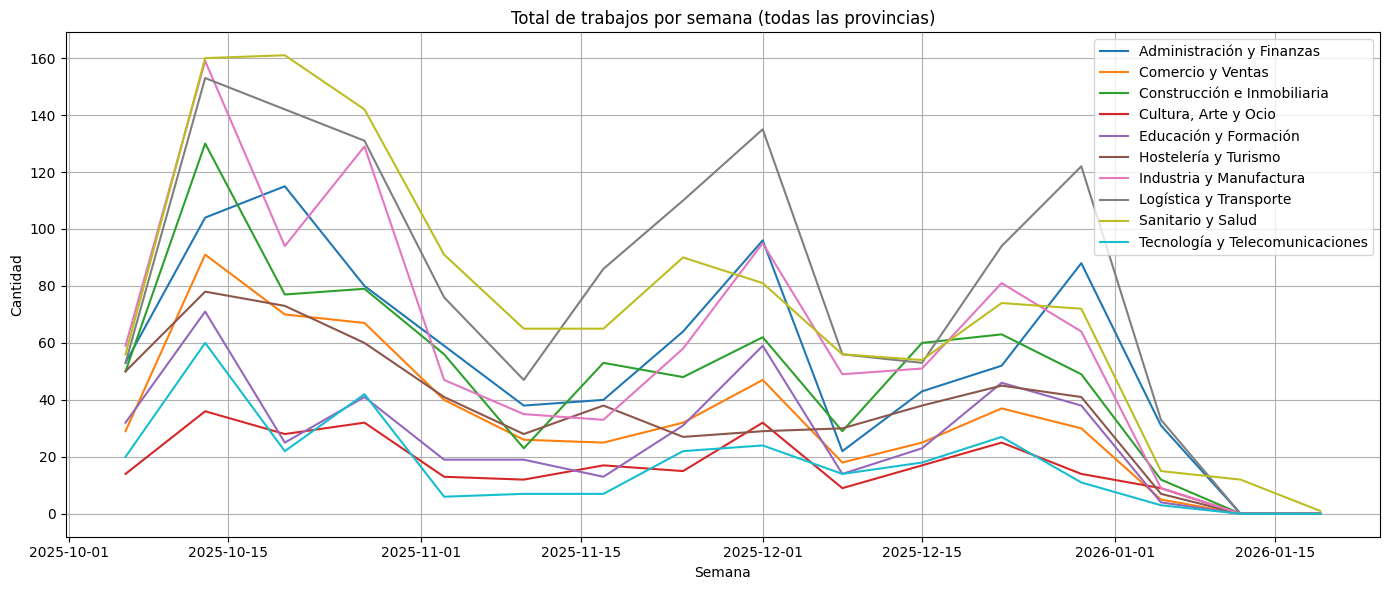

In [32]:
# Gráfico general (todas las provincias)
all_sector_series = {}
for sector in sectores_unicos:
    df_sec = df[df['sector'] == sector]
    grouped = df_sec.groupby('week').count()['count'].reindex(full_weeks, fill_value=0)
    all_sector_series[sector] = grouped

plt.figure(figsize=(14, 6))
for sector, series in all_sector_series.items():
    plt.plot(series.index, series.values, label=sector, color=color_dict[sector])
plt.title('Total de trabajos por semana (todas las provincias)')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Agrupación por comunidad y sector
comunidad_sector_series = {}
for comunidad in df['comunidad'].dropna().unique():
    df_com = df[df['comunidad'] == comunidad]
    sector_series = {}
    for sector in df_com['sector'].unique():
        df_sec = df_com[df_com['sector'] == sector]
        grouped = df_sec.groupby('week').count()['count'].reindex(full_weeks, fill_value=0)
        sector_series[sector] = grouped
    comunidad_sector_series[comunidad] = sector_series

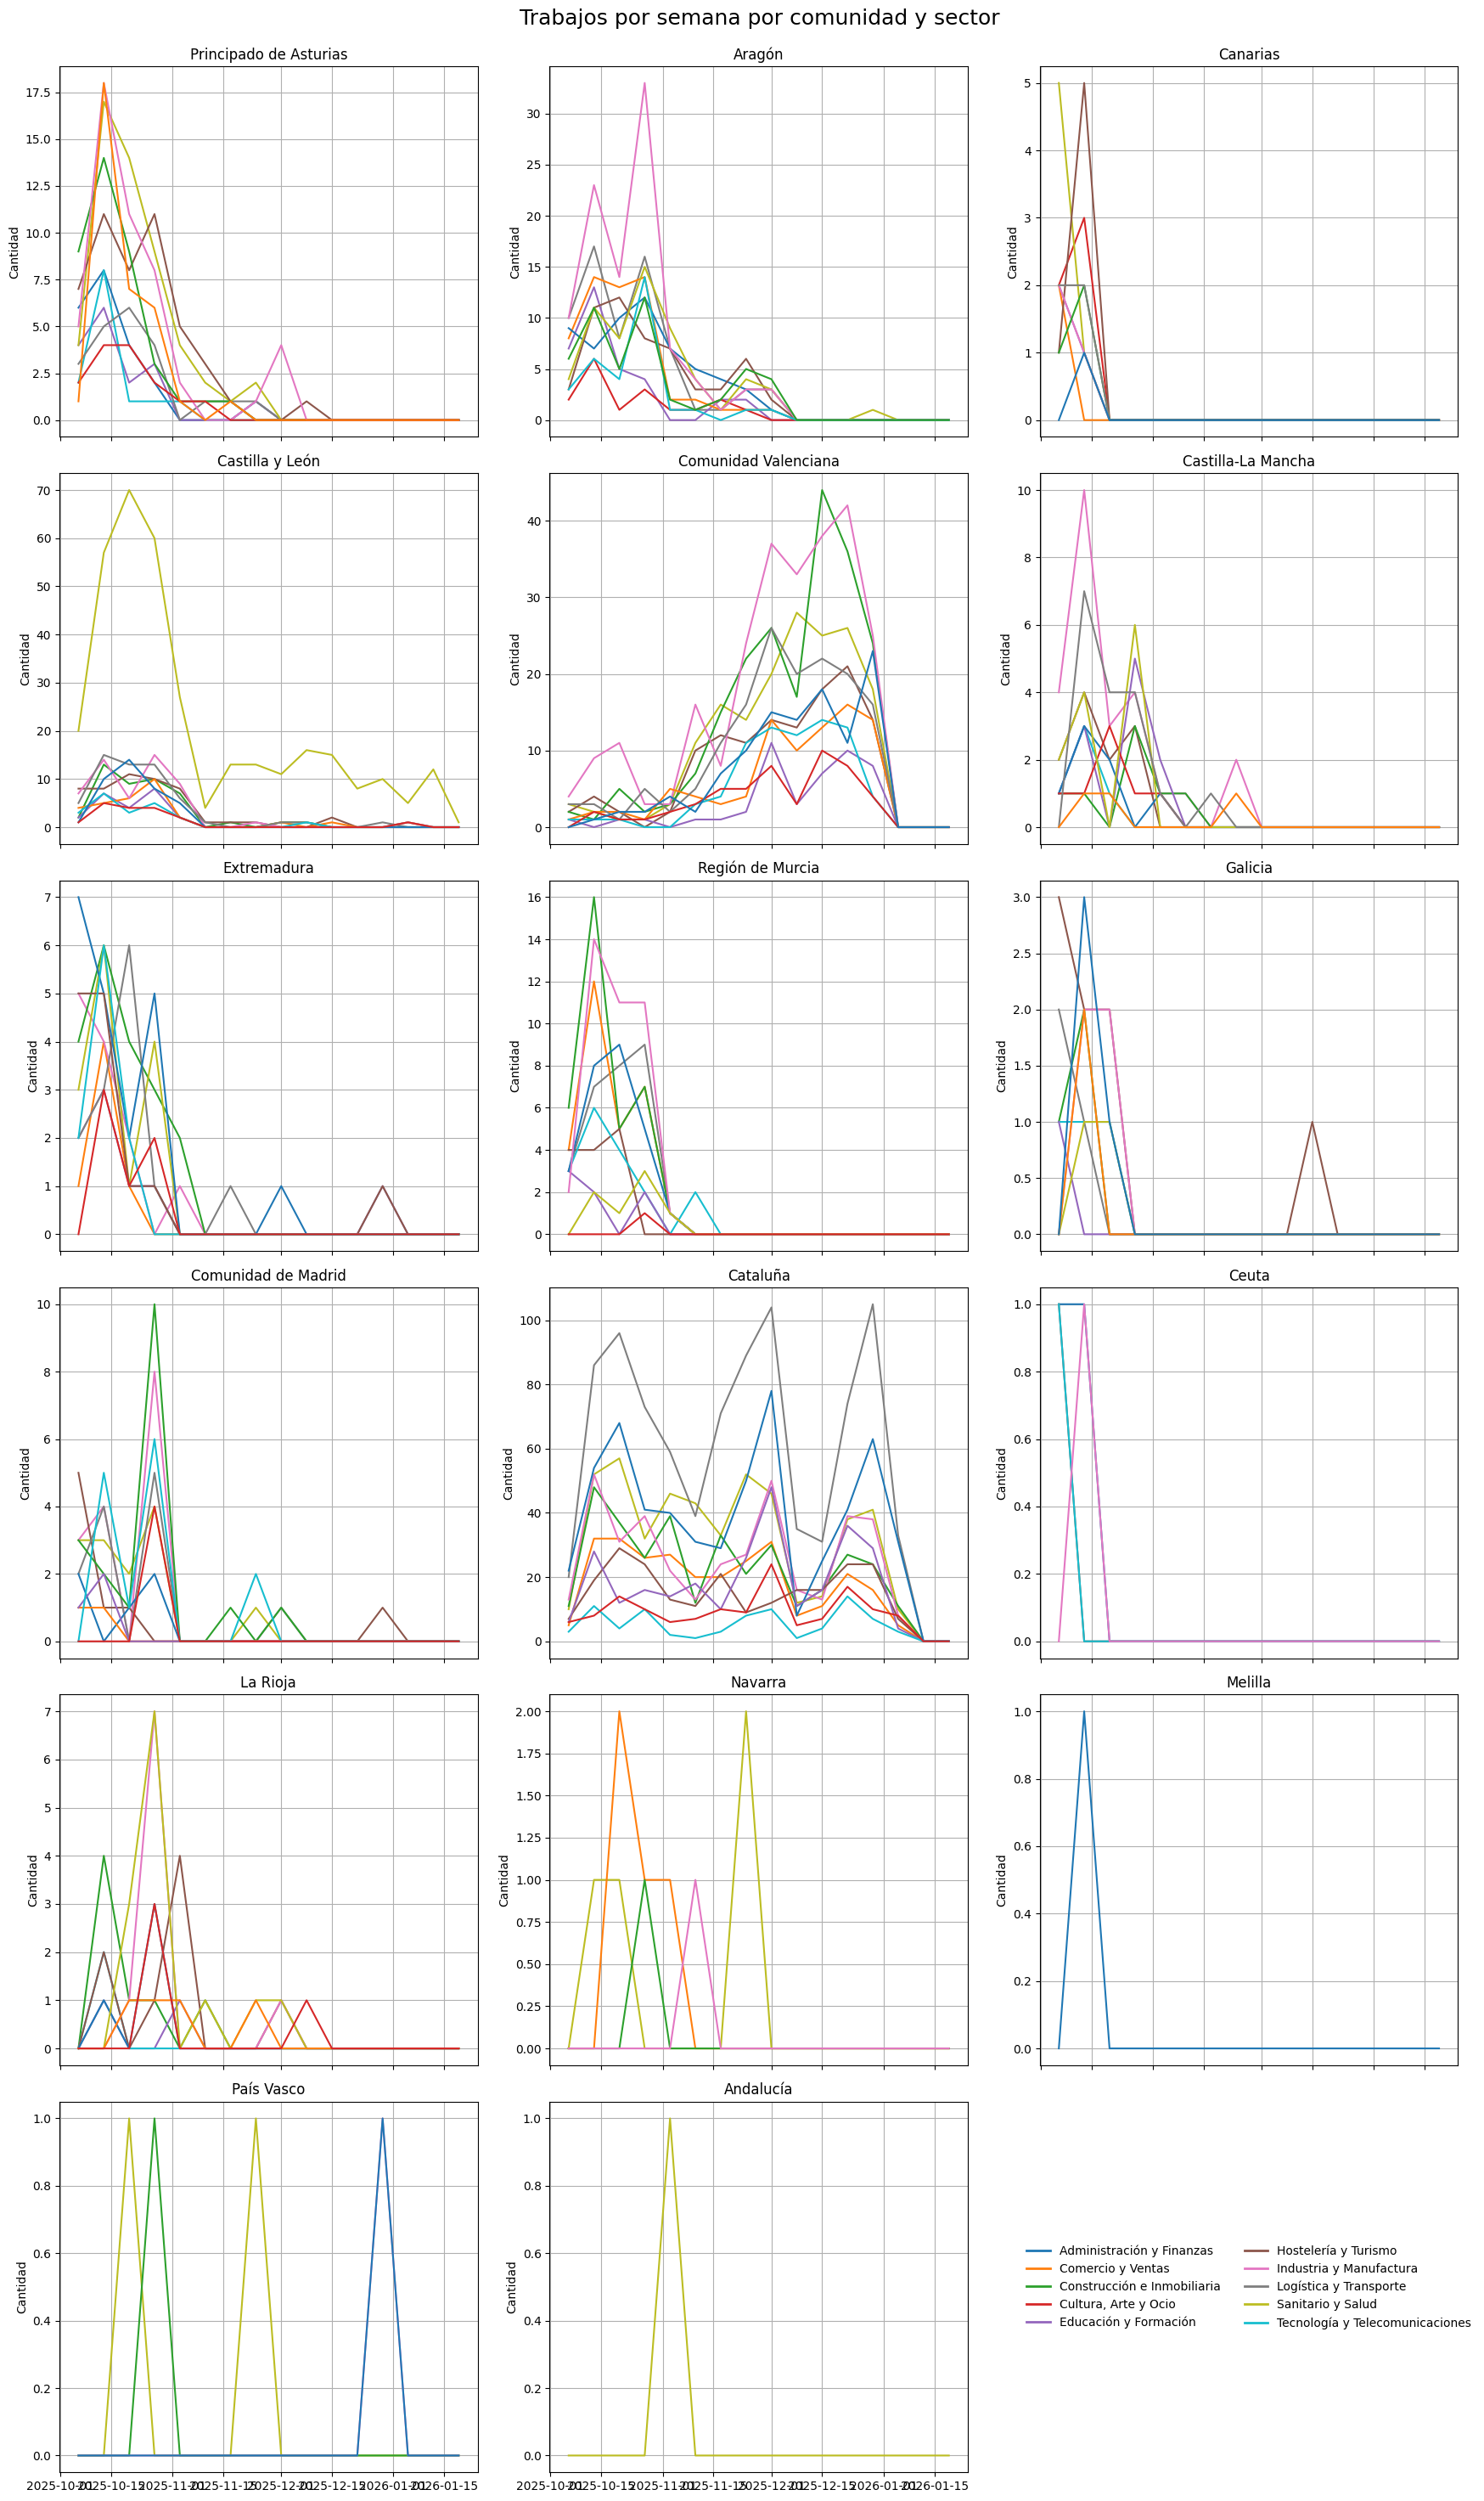

In [50]:
# Subplots por comunidad
n_comunidades = len(comunidad_sector_series)
cols = 3
rows = math.ceil(n_comunidades / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows), sharex=True)
axes = axes.flatten()

# Graficar cada comunidad
for i, (comunidad, sector_data) in enumerate(comunidad_sector_series.items()):
    ax = axes[i]
    for sector, series in sector_data.items():
        ax.plot(series.index, series.values, label=sector, color=color_dict[sector])
    ax.set_title(comunidad)
    ax.set_ylabel('Cantidad')
    ax.grid(True)

# Usar el primer subplot libre para la leyenda
legend_ax_index = i + 1
if legend_ax_index < len(axes):
    legend_ax = axes[legend_ax_index]
    legend_ax.axis('off')
    handles = [plt.Line2D([0], [0], color=color_dict[sector], lw=2) for sector in sectores_unicos]
    labels = sectores_unicos
    legend_ax.legend(handles, labels, loc='center', ncol=2, fontsize='medium', frameon=False)
    for j in range(legend_ax_index + 1, len(axes)):
        axes[j].axis('off')
else:
    handles = [plt.Line2D([0], [0], color=color_dict[sector], lw=2) for sector in sectores_unicos]
    labels = sectores_unicos
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize='medium', frameon=False)
    fig.subplots_adjust(bottom=0.12)

plt.xlabel('Semana')
# plt.tight_layout()
# Ajustar layout dejando espacio arriba para el título
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Subtítulo bien posicionado
fig.suptitle('Trabajos por semana por comunidad y sector', fontsize=18)

plt.show()



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Cargar el CSV ===
df = pd.read_csv("empleos-espanoles-eures-2025-numerico.csv", sep=",")
print("Tamaño del dataset:", df.shape)
df.head()


Tamaño del dataset: (7260, 23)


,id,timestamp,provincia,titulo,sentimiento,Hostelería y Turismo,Sanitario y Salud,Educación y Formación,Tecnología y Telecomunicaciones,Construcción e Inmobiliaria,...,Administración y Finanzas,"Cultura, Arte y Ocio",topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Asturias,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),0,0.041410,0.120989,0.041578,0.059036,0.030720,...,0.324149,0.019736,0.814502,0.026324,0.027557,0.026324,0.026325,0.026324,0.026321,0.026323
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Huesca,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,0,0.030985,0.057478,0.036354,0.029181,0.147310,...,0.018703,0.017910,0.009260,0.009275,0.009260,0.934946,0.009464,0.009271,0.009264,0.009260
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Las Palmas,EDUCADORES SOCIALES,0,0.091417,0.192628,0.193099,0.050107,0.051788,...,0.115695,0.070076,0.055558,0.333313,0.333334,0.055559,0.055560,0.055560,0.055558,0.055559
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Islas Baleares,PIZZERO (REF. 042025002051),0,0.321799,0.063992,0.053844,0.034645,0.072012,...,0.064227,0.136169,0.020914,0.021440,0.020892,0.020867,0.021608,0.123353,0.749986,0.020938
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,Santa Cruz de Tenerife,INTÉRPRETES DE LA LENGUA DE SIGNOS,0,0.080648,0.092984,0.213390,0.103763,0.021884,...,0.032571,0.312398,0.158010,0.683681,0.026455,0.026321,0.026574,0.026321,0.026319,0.026320


In [2]:
# === 2. Identificar columnas de sectores y tópicos ===
sector_cols = [
    "Hostelería y Turismo", "Sanitario y Salud", "Educación y Formación",
    "Tecnología y Telecomunicaciones", "Construcción e Inmobiliaria",
    "Administración y Finanzas", "Cultura, Arte y Ocio"
]

topico_cols = [f"topico_{i}" for i in range(8)]

# Verificamos que existan
print("Sectores encontrados:", [c for c in sector_cols if c in df.columns])
print("Tópicos encontrados:", [c for c in topico_cols if c in df.columns])


Sectores encontrados: ['Hostelería y Turismo', 'Sanitario y Salud', 'Educación y Formación', 'Tecnología y Telecomunicaciones', 'Construcción e Inmobiliaria', 'Administración y Finanzas', 'Cultura, Arte y Ocio']
Tópicos encontrados: ['topico_0', 'topico_1', 'topico_2', 'topico_3', 'topico_4', 'topico_5', 'topico_6', 'topico_7']


In [3]:
# === 3. Calcular el sector y tópico más probables ===
df["sector_mas_probable"] = df[sector_cols].idxmax(axis=1)
df["topico_mas_probable"] = df[topico_cols].idxmax(axis=1)

df[["id", "sector_mas_probable", "topico_mas_probable"]].head()


,id,sector_mas_probable,topico_mas_probable
0,https://europa.eu/eures/portal/jv-se/jv-detail...,Administración y Finanzas,topico_0
1,https://europa.eu/eures/portal/jv-se/jv-detail...,Construcción e Inmobiliaria,topico_3
2,https://europa.eu/eures/portal/jv-se/jv-detail...,Educación y Formación,topico_2
3,https://europa.eu/eures/portal/jv-se/jv-detail...,Hostelería y Turismo,topico_6
4,https://europa.eu/eures/portal/jv-se/jv-detail...,"Cultura, Arte y Ocio",topico_1


In [4]:
# === 4. Conteo cruzado (correlación sector-tópico) ===
tabla_correlacion = pd.crosstab(df["sector_mas_probable"], df["topico_mas_probable"])
tabla_correlacion


topico_mas_probable,topico_0,topico_1,topico_2,topico_3,topico_4,topico_5,topico_6,topico_7
sector_mas_probable,,,,,,,,
Administración y Finanzas,223,100,162,63,91,87,283,59
Construcción e Inmobiliaria,220,170,121,253,113,178,139,170
"Cultura, Arte y Ocio",75,50,24,21,34,35,20,30
Educación y Formación,156,63,86,140,68,107,149,71
Hostelería y Turismo,260,326,133,116,173,181,198,131
Sanitario y Salud,418,172,368,77,104,125,109,146
Tecnología y Telecomunicaciones,98,43,38,144,49,76,177,37


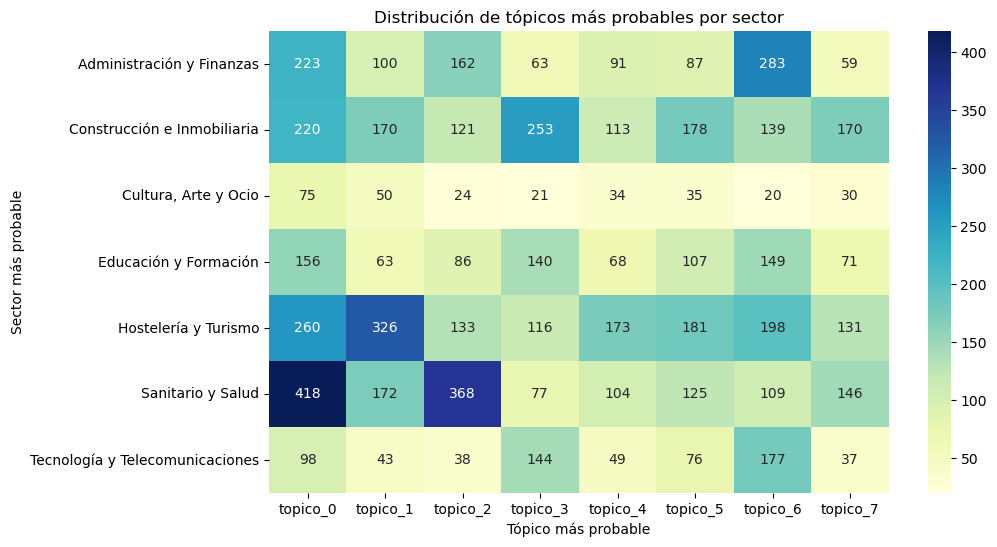

In [5]:
# === 5. Visualización ===
plt.figure(figsize=(10,6))
sns.heatmap(tabla_correlacion, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Distribución de tópicos más probables por sector")
plt.ylabel("Sector más probable")
plt.xlabel("Tópico más probable")
plt.show()


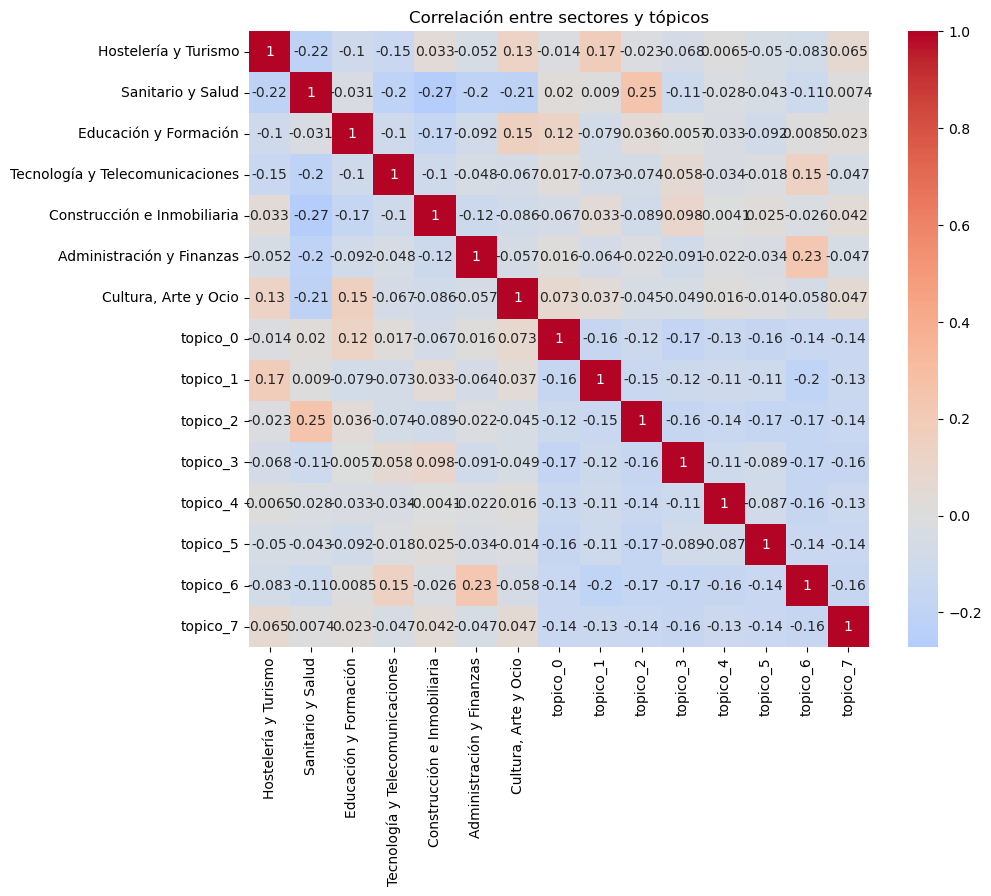

In [6]:
# === 6. Mapa de calor de correlaciones entre columnas numéricas ===

# Seleccionamos solo las columnas de sectores y tópicos 
cols_numericas = sector_cols + topico_cols

# Calculamos la matriz de correlación
corr = df[cols_numericas].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre sectores y tópicos")
plt.show()


In [7]:
# === 7. Correlaciones más fuertes entre sectores y tópicos ===

# Descomponemos la matriz de correlación en pares
corr_pairs = (
    corr.unstack()
    .reset_index()
    .rename(columns={"level_0": "col1", "level_1": "col2", 0: "correlacion"})
)

# Eliminamos duplicados (correlación A-B y B-A) y autovalores (1.0)
corr_pairs = corr_pairs[corr_pairs["col1"] < corr_pairs["col2"]]

# Nos quedamos solo con pares entre sectores y tópicos
mask = corr_pairs["col1"].isin(sector_cols) & corr_pairs["col2"].isin(topico_cols)
corr_pairs = corr_pairs[mask]

# Ordenamos por intensidad (absoluto de la correlación)
corr_pairs["abs_corr"] = corr_pairs["correlacion"].abs()
top_corrs = corr_pairs.sort_values("abs_corr", ascending=False)

print("Top 10 correlaciones más altas (positivas o negativas):")
display(top_corrs.head(10))


Top 10 correlaciones más altas (positivas o negativas):


,col1,col2,correlacion,abs_corr
24,Sanitario y Salud,topico_2,0.250603,0.250603
88,Administración y Finanzas,topico_6,0.231781,0.231781
8,Hostelería y Turismo,topico_1,0.173232,0.173232
58,Tecnología y Telecomunicaciones,topico_6,0.150347,0.150347
37,Educación y Formación,topico_0,0.124686,0.124686
28,Sanitario y Salud,topico_6,-0.112417,0.112417
25,Sanitario y Salud,topico_3,-0.109412,0.109412
70,Construcción e Inmobiliaria,topico_3,0.097606,0.097606
42,Educación y Formación,topico_5,-0.091506,0.091506
85,Administración y Finanzas,topico_3,-0.091405,0.091405
